# Support Vector Machines

* Topic: Supervised machine learning
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Clarke, Simon Bowly, Kaustav Das
* Version: 4

In this lesson we will introduce the the Support Vector Machines (SVM) classifier. We will first explain the concept behind the SVM algorithm and then explain how we can use *kernels* to generate nonlinear boundaries and how we can deal with datasets that have crossover regions.

Support Vector Machines have a regression counterpart called Support Vector Regression (SVR). We only touch on the theory behind this in this notebook, but the principle is the same as its classification counterpart, albeit slightly more complicated.

First, import the necessary libraries.

In [2]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt

## Linear kernels with hard boundaries

Here we will create some artificial datasets using the `sklearn` method `make_blobs`. This creates `n` blobs of data, with each point having coordinates `X` and label `y`. For two centres, we have a binary classification problem.

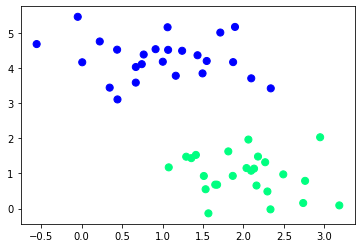

In [3]:
# used to generate the two-dimensional data sets for classification
from sklearn.datasets import make_blobs 

# X are the features of the datasets, and y are the labels. We aim to classify the points based on these labels
# In this case we want two sets of blobs, with 25 points in each and a standard deviation around the centres of 0.6.
X, y  = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6) 
# plot the features and colour the points based on the labels y
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter');

Assume first that the two clusters are clearly separated in feature space. The Support Vector Machine (SVM) classifier then creates decision boundaries between the clusters, rather than assigning a probability to a point being in a particular class as is done for Logistic Regression. For the SVM classifier all data points on either side of the decision boundary are then given a particular label. Consquently, once the training of the model is completed, the classification is simple and rapid. For a binary problem with a linear kernel (kernels will be explained later), the decision boundary will be a hyperplane, or in two-dimensional feature space a line. 

For our blobs data set three possible decision boundaries are shown below. There will be an infinite number of possible decision boundaries which lie between the two clusters. The binary classification of the point marked by a cross, will then depend on the particular chosen decision boundary.

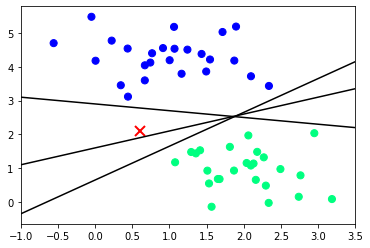

In [4]:
xfit = np.linspace(-1, 3.5) # create a linear array from -1 to 3.5

# plot the features and colour the points based on the labels y
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter')

# plot a red cross at (0.6,2.1) for comparison with the possible deicision boundaries
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# plot three lines of the form y = m*x+b, where we are looping over the values of m and b in the array
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m*xfit+b, '-k')
plt.xlim(-1, 3.5); # set the limits of the figure

For SVM the optimal decision boundary is chosen as the boundary which has the widest open region (i.e., points on the margins of the region are not included) on either side which does not include any points from the binary training sets. This region is defined by two lines or margins (hyperplanes in higher dimensions) which are parallel and equidistant from the decision boundary. The boundary can therefore be found as the solution of an optimization problem, where the width of the strip is maximized. For the three possible decision boundaries being considered, it can be seen the middle line bounded by the orange region has the largest region. However, this is not necessarily the optimal decision boundary. There are other wider regions which could be defined. The optimal region must be in contact with at least two points in one cluster and one point in the other cluster.

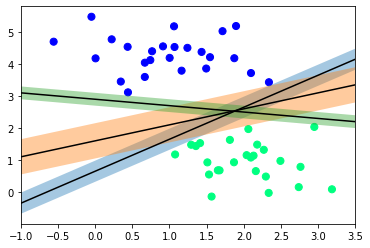

In [5]:
xfit = np.linspace(-1, 3.5) # create a linear array from -1 to 3.5

# plot the features and colour the points based on the labels y
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter')

# plot three lines of the form y = m*x+b, and plot a strip on either side of these lines of width d
# we are now looping over the values of m, b and d in the array
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m*xfit+b
    plt.plot(xfit, yfit, '-k')
     # fill the regions between the upper and lower limits for y
    plt.fill_between(xfit, yfit-d, yfit+d, edgecolor='none', alpha=0.4)
plt.xlim(-1, 3.5); # set the limits of the figure

We now use the SVM classifier `SVC` to determine the optimal boundary for our blobs dataset. The process for fitting the model is the same as other `sklearn` classifiers, e.g., Logistic Regression. We instantatiate the model, then fit the data. Here we will not split the data into testing and training sets, though to test the accuracy of the model this would need to be done. The parameters that are passed to `SVC` are to use linear functions (kernels) for the classifier, which will result in linear decision boundaries, and the parameter `C` is set to a very large value, which means that we have *hard* decision regions, i.e., no training points are allowed to fall in the decision regions. We will investigate later the effect of changing these parameters.

In [6]:
from sklearn.svm import SVC # import the SVM classifier from sklearn

model = SVC(kernel='linear', C=1.E10) # instantatiate the model with a linear kernel and hard boundaries
model.fit(X, y); # fit our blob data to the model

We define a function which will be used to plot the optimal decision strip or region for an SVM classifier (SVC).

The function uses two properties of the SVC. The first of these is the `decision_function`. This is a function which is 0 on the decision boundary and -1 and 1 on the boundaries of the decision region. Therefore the decision region can be identified by plotting the contours where the `decision_function` is -1, 0 and 1. The second property which identifies the decision region is the `support_vectors`, from which the classifier gets its name. These are the training points which are on the boundary of the decision region. The fitting of the model only depends on these points. Any points that are further away from the decision boundary do not modify the fit, as they do not contribute to the width of the decision strip.

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    '''Plot the decision function for a two-dimensional SVC'''
    if ax is None: # check if the axes are specified, if not get the parameters of the current axes
        ax = plt.gca()
    xlim = ax.get_xlim() # retrieve the x limits
    ylim = ax.get_ylim() # retrieve the y limits
    
    x = np.linspace(xlim[0], xlim[1], 30) # create a linear array for the x range of the plot
    y = np.linspace(ylim[0], ylim[1], 30) # create a linear array for the y range of the plot
    X, Y = np.meshgrid(x, y) # create two-dimensional arrays X and Y which have the values of x and y
    # ravel converts X and Y to one dimensional arrays and then we put each of them in the columns of
    # the vector xy
    xy = np.column_stack([X.ravel(), Y.ravel()]) 
    # calculate the values of model decision function at each point xy and then reshape to have 
    # the shape of the two-dimensional array X
    P = model.decision_function(xy).reshape(X.shape)
    # plot the contours corresponding to P=[-1,0,1] in two-dimensional space
    # for P=[-1,1] use dashed line, for P=0 use a solid line
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], linestyles=['--','-','--'])
    
    if plot_support: # if plot_support is True plot the support vectors as a circle surrounding the filled points
        # s specifies the size of the circle, facecolor='none' specifies to not fill the circle
        # and edgecolors='k' specifies to draw a black boundary
        ax.scatter(model.support_vectors_[:,0],
                   model.support_vectors_[:,1],
                   s=300, linewidth=1, facecolor='none', edgecolors='k')
    ax.set_xlim(xlim) # set the x limits
    ax.set_ylim(ylim) # set the y limits

For our blobs data set we now plot the output of the SVC, which is the decision boundary and the support vectors.

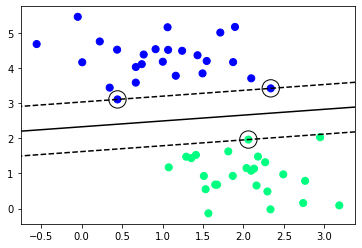

In [8]:
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter') # scatter plot of the blob data
plot_svc_decision_function(model) # overlay the decision boundaries and support vectors

In this case the support vectors have the particular values.

In [9]:
model.support_vectors_ # print the support vectors

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

We can compare the sensitivity of the SVC to the number of points used from a data set. If we take 60 and 120 samples from a dataset of 200 samples, we see that the support vectors do not change as we add further points. If we reduced the number of points used the support vectors would change, e.g., compare this example for 30 and 60 points. However, for a sufficient large number of points the near extreme values of the cluster are sampled and these then determine the decision boundary.

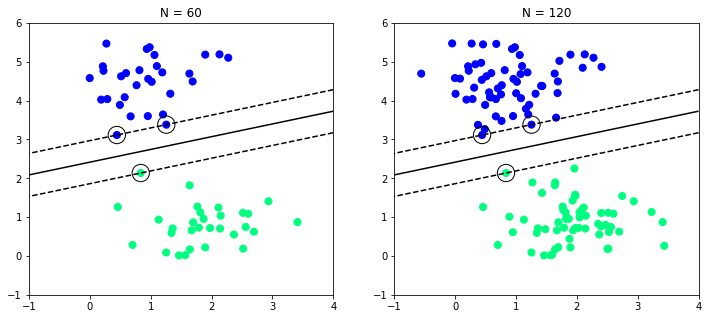

In [10]:
def plot_svm(N=10, ax=None): # set the default values of 10 points and axes are not specified
    '''
    Define a function which generates a blob data set and classifies the first N points
    of this dataset using SVC with a linear kernel and hard boundaries.
    Then plots the dataset and overlays the decision boundaries and support vectors.
    '''
    # generate a blobs dataset with 200 samples
    X, y  = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.6)
    
    X = X[:N] # take the first N features
    y = y[:N] # take the first N labels
    model = SVC(kernel='linear', C=1.E10) # instantatiate the SVC with linear kernel and hard boundaries
    model.fit(X, y) # fit the blobs data using SVC
    
    if ax is None: # check if the axes are specified, if not get the parameters of the current axes
        ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter') # plot the data with labels y
    ax.set_xlim(-1, 4) # set the x limits
    ax.set_ylim(-1, 6) # set the y limits
    plot_svc_decision_function(model, ax) # overlay the decision boundaries and support vectors
    
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # generate axes to two subplots in a figure of size (12,5) 
# zip bundles the two arrays together, loop through the axes and the values of N that we want to plot
for axi, N in zip(ax, [60, 120]): 
    plot_svm(N, axi) # classify and plot the blobs data set for the given value of N
    axi.set_title('N = {0}'.format(N)) # add a title which includes the current value of N

## Nonlinear boundaries

What we have done so far could have been easily achieved with another linear classifier such as Logistic Regression. The power of the SVM algorithm is that *kernels* allow classification to occur with nonlinear boundaries. Kernels essentially correspond to using a different basis function for the classification. For a linear basis functions the kernel has the form

$$ \phi(X,Y) = X^T Y = X_1Y_1+X_2Y_2+\cdots+X_nY_n, $$

where $X$ and $Y$ are two points or vectors in decision space and each has n features. This is also known as the dot product of the two vectors. The kernel must be a scalar and be symmetric, i.e., $\phi(X,Y) = \phi(Y,X)$. From this it is apparent that, as for the other regression models and classifiers that have been considered, it is important to make sure the feature data is normalized.

Consider the following example using the `sklearn` method `make_circles`, which creates two sets of data which lie approximately on two circles and have different labels on each circle. The scale of the inner and outer circle is determined by the parameter `factor`. If we try to use a linear classifier such as SVC, this is unable to separate the two datasets.

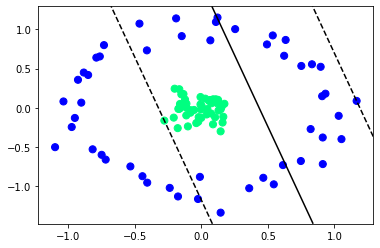

In [11]:
# used to generate the two-dimensional data sets for classification
from sklearn.datasets import make_circles 

# make two datasets which are approximately circles, each with 50 points, the ratio of the circles is specified
# by factor and the amount of noise is specified by noise
X, y  = make_circles(100, factor=0.1, noise=0.1, random_state=0) 

clf = SVC(kernel='linear') # instantatiate the SVC with linear kernel and the default value of C=1
clf.fit(X, y) # fit the circle data using SVC

plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter') # plot the data labelled by y
plot_svc_decision_function(clf, plot_support = False); # overlay the decision function boundaries

However, we can add an extra dimension to our data which is a Gaussian function dependent on the distance from the origin in the original plane.

In [12]:
# calculate a Guassian radial basis function, sum(1) denotes to sum of the second component
r = np.exp(-( X**2 ).sum(1)) 

Then plotting the data in three dimensions we can clearly identify a linear decision boundary at approximately r=0.7, which separates the two datasets.

Text(0.5, 0, 'r')

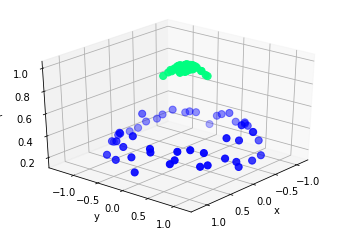

In [13]:
from mpl_toolkits import mplot3d # import function to enable 3-dimensional plotting in matplotlib

ax = plt.subplot(projection = '3d') # setup figure for a 3-d plot
ax.scatter3D(X[:, 0], X[:, 1], r, c = y, s = 50, cmap = 'winter') # 3d scatter of X (2 components) and r, labelled by y
ax.view_init(elev=30, azim=40) # set in degrees the elevation and azimuthal angle for plot
ax.set_xlabel('x') # x label
ax.set_ylabel('y') # y label
ax.set_zlabel('r') # z label

Another way to classify this data would be to plot the data in polar coordinates in terms of the radius and angle of each point about a point in feature space. This point needs to be chosen so that the decision boundaries are vertical lines, since they must be periodic. In this case SVC is easily able to delineate the two datasets. In terms of the original variables, these decision boundaries are then circles.

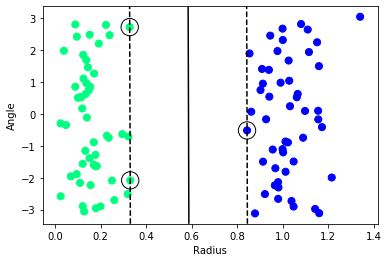

In [14]:
Z = np.zeros(X.shape) # create an array of zeros with the same shape as X
Z[:,0] = np.sqrt((X[:,0]-.01)**2 + X[:,1]**2) # first component is the distance from (.01,0)
Z[:,1] = np.arctan2(X[:,0]-.01, X[:,1]) # second component is the angle between X and (.01,0)

clf = SVC(kernel='linear',C=1.E10) # instantatiate SVC with linear kernel and hard boundaries
clf.fit(Z, y) # fit the Z and y data to the model
plt.scatter(Z[:,0], Z[:,1], c=y, s=50, cmap='winter') # scatter plot of Z labelled by y
plot_svc_decision_function(clf, plot_support=True); # plot the decision boundaries and support vectors
plt.xlabel('Radius') # x label
plt.ylabel('Angle'); # y label

The Gaussian or exponential function dependent on the distance from the origin is known as a radial basis function or `rbf`. If we specify the `kernel='rbf'` then radial basis functions are used to transform the data to a new feature space. They are then classified in the new feature space using `SVC`. The actual form of the kernel for radial basis functions used in the SVC is

$$ \phi(X,Y) = \exp (-{\rm gamma } (d(X,Y))^2 ), $$

where $d(X,Y)$ is the distance between points $X$ and $Y$ in feature space. The accuracy of the classifier is therefore dependent on the parameter `gamma`, which needs to be specified in calling `SVC`. Setting `gamma=auto` sets this to a default value. The optimal value of this hyperparameter should be determined using a cross-validation grid search, such as the `sklearn` function `GridSearchCV`.

In [15]:
clf = SVC(kernel='rbf', C=1.E6, gamma='auto') # instantatiate SVC with rbf kernel and hard boundaries
clf.fit(X, y); # fit the X and y data using SVC

Now plotting the decision function and the support vectors it can be seen that SVC is able to correctly classify the circles dataset. Now the decision boundaries are ellipses.

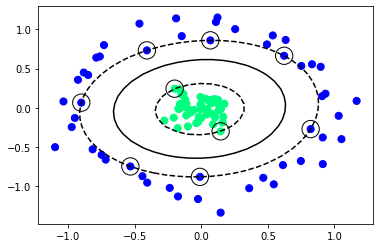

In [16]:
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter') # scatter plot of X labelled by y
plot_svc_decision_function(clf) # plot the decision boundaries and support vectors

Radial basis functions are just one type of kernel that can be used by SVC. Other options are polynomials, the sigmoid function (a smooth step function similar to the logistic function), and user defined kernel functions. Each of these functions are dependent of particular hyperparameters for which the optimal parameters must be determined by cross-validation grid search.

## Soft boundaries

So far we have only considered datasets which are clearly dilineated in feature space, and for that we have set the hyperparameter `C` to some large value. However, if the datasets merge in some region we can relax the hardness of the boundaries by using smaller values of `C`. This allows somes data points to lie in the decision region. 

For example, if we return to the blobs dataset but increase the standard deviation then we have a region of crossover of our datasets. In this case, if we specify a hard boundary we would not be able to separate the two datasets, and the width of the decision boundary would go to zero.

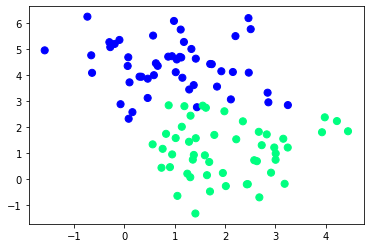

In [17]:
# create a blobs dataset with a larger standard deviation so that the blobs intersect
X, y  = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter'); # scatterplot of blobs 

We can compare the effect of changing `C` for this dataset. For large `C` the width of the decision strip becomes smaller, with only a few points lying in this region. For smaller `C` the margins are softer and the decision strip grows in width, with more points lying in this region.

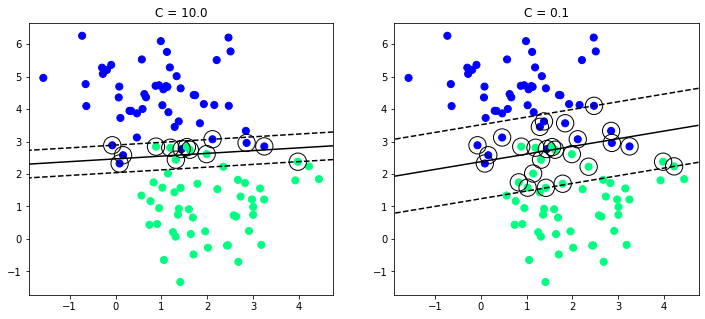

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # setup two subplots on figures of size (12,5)

# zip bundles together the axis indices and values of C, and we loop over these
for axi, C in zip(ax, [10.0, 0.1]): 
    model = SVC(kernel='linear', C=C) # instantatiate SVC with linear kernels and variable softness of boundaries
    model.fit(X, y) # fit X and y using SVC
    axi.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter') # scatterplot of blobs
    plot_svc_decision_function(model, axi) # overlay decision boundaries and support vectors on current axes
    axi.set_title('C = {0:.1f}'.format(C)) # add a title which include current value of C to 1 decimal place

The optimal value of `C` would again need to be determined by investigating the accuracy for a test set using a cross-validation grid search.

## Support Vector Regression (SVR)

The algorithm for SVM (classification) can be adapted for regression. The idea is similar, however the mathematical optimisation is different, naturally this is due to the continuous nature of the target variable.

The routine from `sklearn` for support vector regression is called `SVR` and can be instantiated in a similar way to how we instantiated `SVC`. An example of this is done in Exercise 2 below.

## Exercises

For the exercises we will be investigating the Penguins dataset which is builtin to `seaborn`. It classifies three species of penguins on islands in the South Atlantic based on four physical characteristics. It can be imported in the same manner as the Iris dataset.

In [19]:
import pandas as pd
import seaborn as sns

penguins = sns.load_dataset('penguins')

We first need to do some preliminary EDA on the data. If we look at the header it is apparent that there are missing entries, as signified by `NaN`.

In [20]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We are not going to use the sex of the penguins or the island that they are found on, however the four other characteristics will be investigated. We can then investigate how many rows having missing entries.

In [21]:
penguins[penguins.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


There are only two rows with missing entries in the physical characteristics, so we will drop these.

In [22]:
penguins.dropna(subset=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'],
                how='any',inplace=True)
penguins.shape

(342, 7)

This leaves us with a dataframe of 342 entries. Now we will concentrate on the features of interest.

First, we can investigate the species of penguins.

In [23]:
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

Then we can look at the descriptive statistics for the numerical values.

In [24]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Another way to investigate these features is to plot histograms of the features, which shows that the features are clearly not normally distributed.

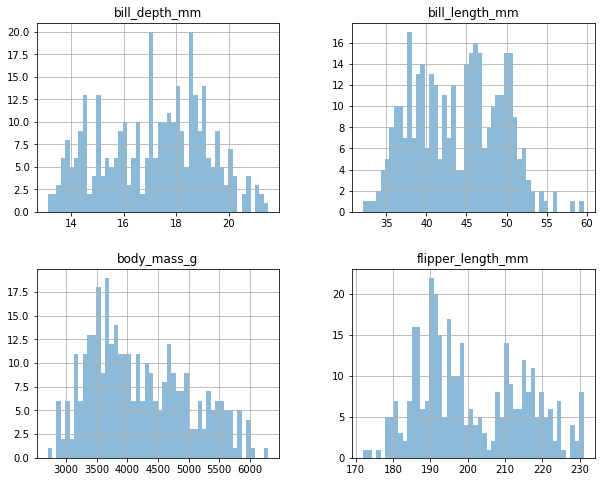

In [25]:
penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].hist(alpha=0.5, bins=50,
                                                                                   figsize=(10,8));

We can also create scatter plots of the classifications as a function of the numerical features. In this case we will concentrate on the bill measurements. If you investigate the other features it is apparent that the classifications are much more delineated.

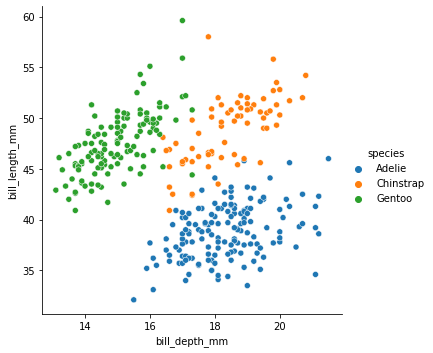

In [26]:
sns.relplot(x="bill_depth_mm", y="bill_length_mm", hue='species', data=penguins);

We first will attempt to model the Chinstrap penguin as a function of the bill measurements using SVM with a linear kernel. The first step is to convert the classification to binary columns using one-hot-encoding.

In [27]:
penguins['code'] = penguins.species.astype('category').cat.codes 
one_hots = pd.get_dummies(penguins['species'], prefix = 'species')
penguins = pd.concat([penguins, one_hots], axis = 1)
    
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,code,species_Adelie,species_Chinstrap,species_Gentoo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,1,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,1,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,1,0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,1,0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,1,0,0


Next we create our feature table and our target variable, and then normalize the feature variables.

In [28]:
X = penguins[['bill_length_mm','bill_depth_mm']]
Y = penguins['species_Chinstrap']


### Normalisation. Can also achieve this with the StandardScaler from sklearn
XX = (X-X.mean())/X.std();

Then we split these tables into testing and training sets. Note that because of the cost of SVM, we split them into equal sets.

In [29]:
from sklearn.model_selection import train_test_split # import the splitting method from sklearn

X_train, X_test, Y_train, Y_test = train_test_split(
    XX, Y, 
    test_size=0.5, 
    random_state=0
) 

We can now model the species using SVM with a linear kernel and hard boundaries. This may take some time.

In [30]:
from sklearn.svm import SVC # import the SVM classifier from sklearn

model = SVC(kernel='linear', C=1.E10) # instantatiate the model with a linear kernel and hard boundaries
model.fit(X_train, Y_train); # fit our data to the model

The model can be assessed by plotting the SVC decision function against the training variables. As is apparent, the fit is not particularly great.

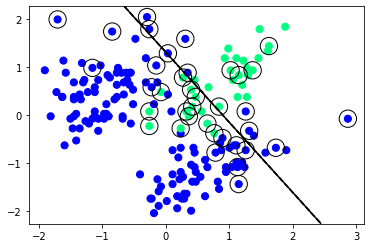

In [31]:
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=Y_train, s=50, cmap='winter') # scatter plot of the data
plot_svc_decision_function(model) # overlay the decision boundaries and support vectors

We could investigate the confusion matrix, but here we will just concentrate on the accuracy measurements for the test set.

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 

y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(Y_test, y_pred):.3f}') # calculate and print the accuracy score
print(f'Precision: {precision_score(Y_test, y_pred):.3f}') # calculate and print the precision score
print(f'Recall: {recall_score(Y_test, y_pred):.3f}') # calculate and print the recall score

Accuracy: 0.895
Precision: 0.767
Recall: 0.676


This shows that the model is reasonable, but clearly the boundary is not a linear hyperplane. Therefore, rather than experiment on changing the hardness of the boundaries, it is better to investigate using nonlinear kernels.

### Exercise 1

Use SVC with `rbf` and `poly` kernels to try to get a better accuracy for the penguins model, i.e., predicting the Chinstrap species using the `bill_length_mm` and `bill_depth_mm` features. For the polynomial kernel, use degree=3 (the default value) and investigate varying `coef0` and `C`. For the rbf kernel investigate varying `gamma` and `C`. By varying the coefficients and the hardness of the boundaries, you should be able to achieve an accuracy of at least 95% for both nonlinear kernels.

Hint: You may want to have a look at the routine `GridSearchCV` from scikit-learn. This helps us find optimal hyperparameters by iterating over a chosen input list of possible hyperparameters. For this exercise this is optional, instead you can manually find the best hyperparameters via trial and error. Warning, SVM is computationally intensive, so use `GridSearchCV` with caution! 

In [33]:
X_ex1 = penguins[['bill_length_mm','bill_depth_mm']]
Y_ex1 = penguins['species_Chinstrap']

# Standardising
XX_ex1 = (X_ex1-X_ex1.mean())/X_ex1.std();

In [34]:
# Split the data into a 50:50 training/testing split

X_train, X_test, Y_train, Y_test = train_test_split(
    XX_ex1, Y, 
    test_size = 0.5, 
    random_state = 0
) 

In [35]:
from sklearn.model_selection import GridSearchCV

# Optional: If you want to utilise GridSearchCV to find the optimal hyperparameters, define 
# the following parameter set (here this would be for a poly kernel):

parameters = {'C': [0.01, 0.1, 1, 10, 100], 
              'coef0': [1, 0.1, 0.01],
             'kernel':['poly']} 

# You will need to look into how to call GridSearchCV. Adjusting this to the rbf kernel shouldn't be a problem! The .best_params
# method will yield the best parameters chosen by GridSearchCV

Optimal parameters for polynomial kernel.

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare the data
X_ex1 = penguins[['bill_length_mm', 'bill_depth_mm']]
Y_ex1 = penguins['species_Chinstrap']

# Standardize the features
XX_ex1 = (X_ex1 - X_ex1.mean()) / X_ex1.std()

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    XX_ex1, Y_ex1, test_size=0.5, random_state=0
)

# Create an SVM model with RBF kernel
model_rbf = SVC(kernel='rbf', C=1, gamma='auto')

# Fit the model to the training data
model_rbf.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_rbf = model_rbf.predict(X_test)

# Calculate accuracy
accuracy_rbf = accuracy_score(Y_test, y_pred_rbf)
print(f'RBF Kernel Accuracy: {accuracy_rbf:.3f}')


RBF Kernel Accuracy: 0.965


Optimal parameters for rbf kernel.

In [37]:
# Create an SVM model with polynomial kernel
model_poly = SVC(kernel='poly', C=1, degree=3, coef0=1)

# Fit the model to the training data
model_poly.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_poly = model_poly.predict(X_test)

# Calculate accuracy
accuracy_poly = accuracy_score(Y_test, y_pred_poly)
print(f'Poly Kernel Accuracy: {accuracy_poly:.3f}')


Poly Kernel Accuracy: 0.971


### Exercise 2

In this exercise we will utilise Support Vector Regression (SVR) to do regression. We will use the `bill _length_mm` and `bill_depth_mm` features to predict the target `flipper_length_mm`.

In [38]:
X_ex2 = penguins[['bill_length_mm','bill_depth_mm']]
Y_ex2 = penguins['flipper_length_mm']

# Standardising
nX_ex2 = (X_ex2-X_ex2.mean())/X_ex2.std();

In [39]:
# Split the data into a 50:50 training/testing split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_ex2, Y_ex2, 
    test_size = 0.5, 
    random_state = 0
) 

Below I have utilised SVR with a linear kernel and computed the RMSE, MAE and R2 score.

In [40]:
from sklearn.svm import SVR # import the SVM regressor from sklearn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values

reg = SVR(kernel='linear', C=1) # instantatiate the model
reg.fit(X_train, Y_train); # fit our data to the model
y_pred = reg.predict(X_test)

# Print off the MAE, RMSE and r2 score
print(f'RMSE is {mean_squared_error(Y_test, y_pred, squared = False):.3f}')
print(f'MAE is {mean_absolute_error(Y_test, y_pred):.3f}')
print(f'R2 score is {r2_score(Y_test, y_pred):.3f}')

RMSE is 8.764
MAE is 6.972
R2 score is 0.594


Your task is to utilise SVR with non-linear kernels. Use SVR with `rbf` and `poly` kernels to try to get a better R2 score. For the polynomial kernel, use degree=3 (the default value) and investigate varying `coef0` and `C`. For the rbf kernel investigate varying `gamma` and `C`.

In [41]:
from sklearn.model_selection import GridSearchCV

# Optional: If you want to utilise GridSearchCV to find the optimal hyperparameters, define 
# the following parameter set (here this would be for a poly kernel):

parameters = {'C': [0.01, 0.1, 1, 10, 100], 
              'coef0': [1, 0.1, 0.01],
             'kernel':['poly']} 

# You will need to look into how to call GridSearchCV. Adjusting this to the rbf kernel shouldn't be a problem! The .best_params
# method will yield the best parameters chosen by GridSearchCV

Optimal parameters for polynomial kernel:

In [42]:
# Create an SVR model with RBF kernel
reg_rbf = SVR(kernel='rbf', C=1, gamma='auto')

# Fit the model to the training data
reg_rbf.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_rbf = reg_rbf.predict(X_test)

# Calculate RMSE, MAE, and R2 score
rmse_rbf = mean_squared_error(Y_test, y_pred_rbf, squared=False)
mae_rbf = mean_absolute_error(Y_test, y_pred_rbf)
r2_rbf = r2_score(Y_test, y_pred_rbf)

print(f'RBF Kernel RMSE: {rmse_rbf:.3f}')
print(f'RBF Kernel MAE: {mae_rbf:.3f}')
print(f'RBF Kernel R2 Score: {r2_rbf:.3f}')


RBF Kernel RMSE: 9.323
RBF Kernel MAE: 7.146
RBF Kernel R2 Score: 0.540


R2 score for polynomial kernel:

In [43]:
# Create an SVR model with polynomial kernel
reg_poly = SVR(kernel='poly', C=1, degree=3, coef0=1)

# Fit the model to the training data
reg_poly.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_poly = reg_poly.predict(X_test)

# Calculate RMSE, MAE, and R2 score
rmse_poly = mean_squared_error(Y_test, y_pred_poly, squared=False)
mae_poly = mean_absolute_error(Y_test, y_pred_poly)
r2_poly = r2_score(Y_test, y_pred_poly)

print(f'Poly Kernel RMSE: {rmse_poly:.3f}')
print(f'Poly Kernel MAE: {mae_poly:.3f}')
print(f'Poly Kernel R2 Score: {r2_poly:.3f}')


Poly Kernel RMSE: 8.576
Poly Kernel MAE: 6.674
Poly Kernel R2 Score: 0.611


Optimal parameters for rbf kernel:

In [44]:
# Create an SVR model with rbf kernel
reg_rbf = SVR(kernel='rbf', C=1, gamma='auto')

# Fit the model to the training data
reg_rbf.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_rbf = reg_rbf.predict(X_test)

# Calculate RMSE, MAE, and R2 score for rbf kernel
rmse_rbf = mean_squared_error(Y_test, y_pred_rbf, squared=False)
mae_rbf = mean_absolute_error(Y_test, y_pred_rbf)
r2_rbf = r2_score(Y_test, y_pred_rbf)

print(f'RBF Kernel RMSE: {rmse_rbf:.3f}')
print(f'RBF Kernel MAE: {mae_rbf:.3f}')
print(f'RBF Kernel R2 Score: {r2_rbf:.3f}')


RBF Kernel RMSE: 9.323
RBF Kernel MAE: 7.146
RBF Kernel R2 Score: 0.540


R2 score for rbf kernel:

In [45]:
# Create an SVR model with polynomial kernel
reg_poly = SVR(kernel='poly', C=1, degree=3, coef0=1)

# Fit the model to the training data
reg_poly.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_poly = reg_poly.predict(X_test)

# Calculate RMSE, MAE, and R2 score for polynomial kernel
rmse_poly = mean_squared_error(Y_test, y_pred_poly, squared=False)
mae_poly = mean_absolute_error(Y_test, y_pred_poly)
r2_poly = r2_score(Y_test, y_pred_poly)

print(f'Poly Kernel RMSE: {rmse_poly:.3f}')
print(f'Poly Kernel MAE: {mae_poly:.3f}')
print(f'Poly Kernel R2 Score: {r2_poly:.3f}')


Poly Kernel RMSE: 8.576
Poly Kernel MAE: 6.674
Poly Kernel R2 Score: 0.611
